<center>
  <h1 style="background-color:red; color:white; font-size:40px; font-weight:bold; font-family:Times New Roman; border:3px solid black;">GROUP 80 - Amazon Reviews For Sentiment Analysis</h1>
</center>

# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #003380; border: 10px solid #80ffff"> TABLE OF CONTENTS<br><div>  

* Import Libraries
* Read Data & Text Cleaning
* Word Cloud
* Tokeniztion & pad_sequences
* Model
* Evaluate

<a id="0.1"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" >Import Libraries<br><div> 


In [2]:
import bz2
import re
import pickle
import gc
import multiprocessing

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,SpatialDropout1D,Embedding
from keras.callbacks import ModelCheckpoint

from joblib import Parallel, delayed

plt.style.use('ggplot')

<a id="0.1"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" >Read Data & Text Cleaning<br><div> 


output_path='/kaggle/working/train.ft.txt'
with bz2.open('/kaggle/input/amazonreviews/train.ft.txt.bz2', 'rt', encoding='utf-8') as compressed_file, open(output_path, 'w', encoding='utf-8') as output_file:
    for line in compressed_file:
        output_file.write(line)
    print('Train Successful ❤')
output_path='/kaggle/working/test.ft.txt'
with bz2.open('/kaggle/input/amazonreviews/test.ft.txt.bz2', 'rt', encoding='utf-8') as compressed_file, open(output_path, 'w', encoding='utf-8') as output_file:
    for line in compressed_file:
        output_file.write(line)
    print('Test Successful ❤')

train,test,train_label,test_label=[],[],[],[]
with open('train.ft.txt', 'r', encoding='utf-8') as file:
    lines = file.readlines()
for line in tqdm(lines):
    train.append(line.split('__label__')[1][1:])
    train_label.append(line.split('__label__')[1][0])
with open('test.ft.txt', 'r', encoding='utf-8') as file:
    lines = file.readlines()
for line in tqdm(lines):
    test.append(line.split('__label__')[1][1:])
    test_label.append(line.split('__label__')[1][0])

def get_labels_and_texts(file):
    labels = []
    texts = []
    for line in bz2.BZ2File(file):
        x = line.decode("utf-8")
        labels.append(int(x[9]) - 1)
        texts.append(x[10:].strip())
    return np.array(labels), texts
train_labels, train_texts = get_labels_and_texts('../input/train.ft.txt.bz2')
test_labels, test_texts = get_labels_and_texts('../input/test.ft.txt.bz2')

In [3]:
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to preprocess text
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove URLs
    text = re.sub(r'(?:https?:\/\/(?:www\.|(?!www))|www\.)[\w\-\.\+/?=&#@:%~]+', 'URL', text)
    # Remove punctuation and special characters
    text = re.sub(r'[\W_]+', ' ', text)
    # Tokenize and remove stop words
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# Load data
def preprocess_data_from_file(filepath):
    # Read the file
    with open(filepath, 'r') as file:
        lines = file.readlines()
    
    labels = []
    texts = []
    for line in lines:
        label, text = line.split(' ', 1)
        label = int(label.split('__label__')[1])
        labels.append(label)
        texts.append(text.strip())
    
    # Parallelize the preprocessing of text
    num_cores = multiprocessing.cpu_count()
    processed_texts = Parallel(n_jobs=num_cores)(delayed(preprocess_text)(text) for text in texts)
    
    # Create DataFrame
    df = pd.DataFrame({'label': labels, 'text': processed_texts})
    
    return df

# Load data bz2
def get_preprocess_data_bz2(filepath):
    labels = []
    texts = []
    for line in bz2.BZ2File(filepath):
        x = line.decode("utf-8")
        labels.append(int(x[9]) - 1)
        texts.append(x[11:].strip())
    num_cores = multiprocessing.cpu_count()
    processed_texts = Parallel(n_jobs=num_cores)(delayed(preprocess_text)(text) for text in texts)
    return pd.DataFrame({'label': labels, 'text': processed_texts})

# Load data
train_filepath = 'train.3270.txt'
df_train = preprocess_data_from_file(train_filepath)
test_filepath = 'test.135.txt'
df_test = preprocess_data_from_file(test_filepath)

#train_filepath = r'D:/WORKSPACE/ai_advance/workshop/workshop2/topic3/train.ft.txt.bz2'
# df_train = get_preprocess_data_bz2(train_filepath)
# test_filepath = r'D:/WORKSPACE/ai_advance/workshop/workshop2/topic3/test.ft.txt.bz2'
# df_test = get_preprocess_data_bz2(test_filepath)


# Split data into features and labels
X = df_train['text']
y = df_train['label']

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
del lemmatizer, stop_words, stopwords, train_filepath, df_train

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HUYNGUYEN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HUYNGUYEN\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<a id="0.1"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" >Word Cloud<br><div> 


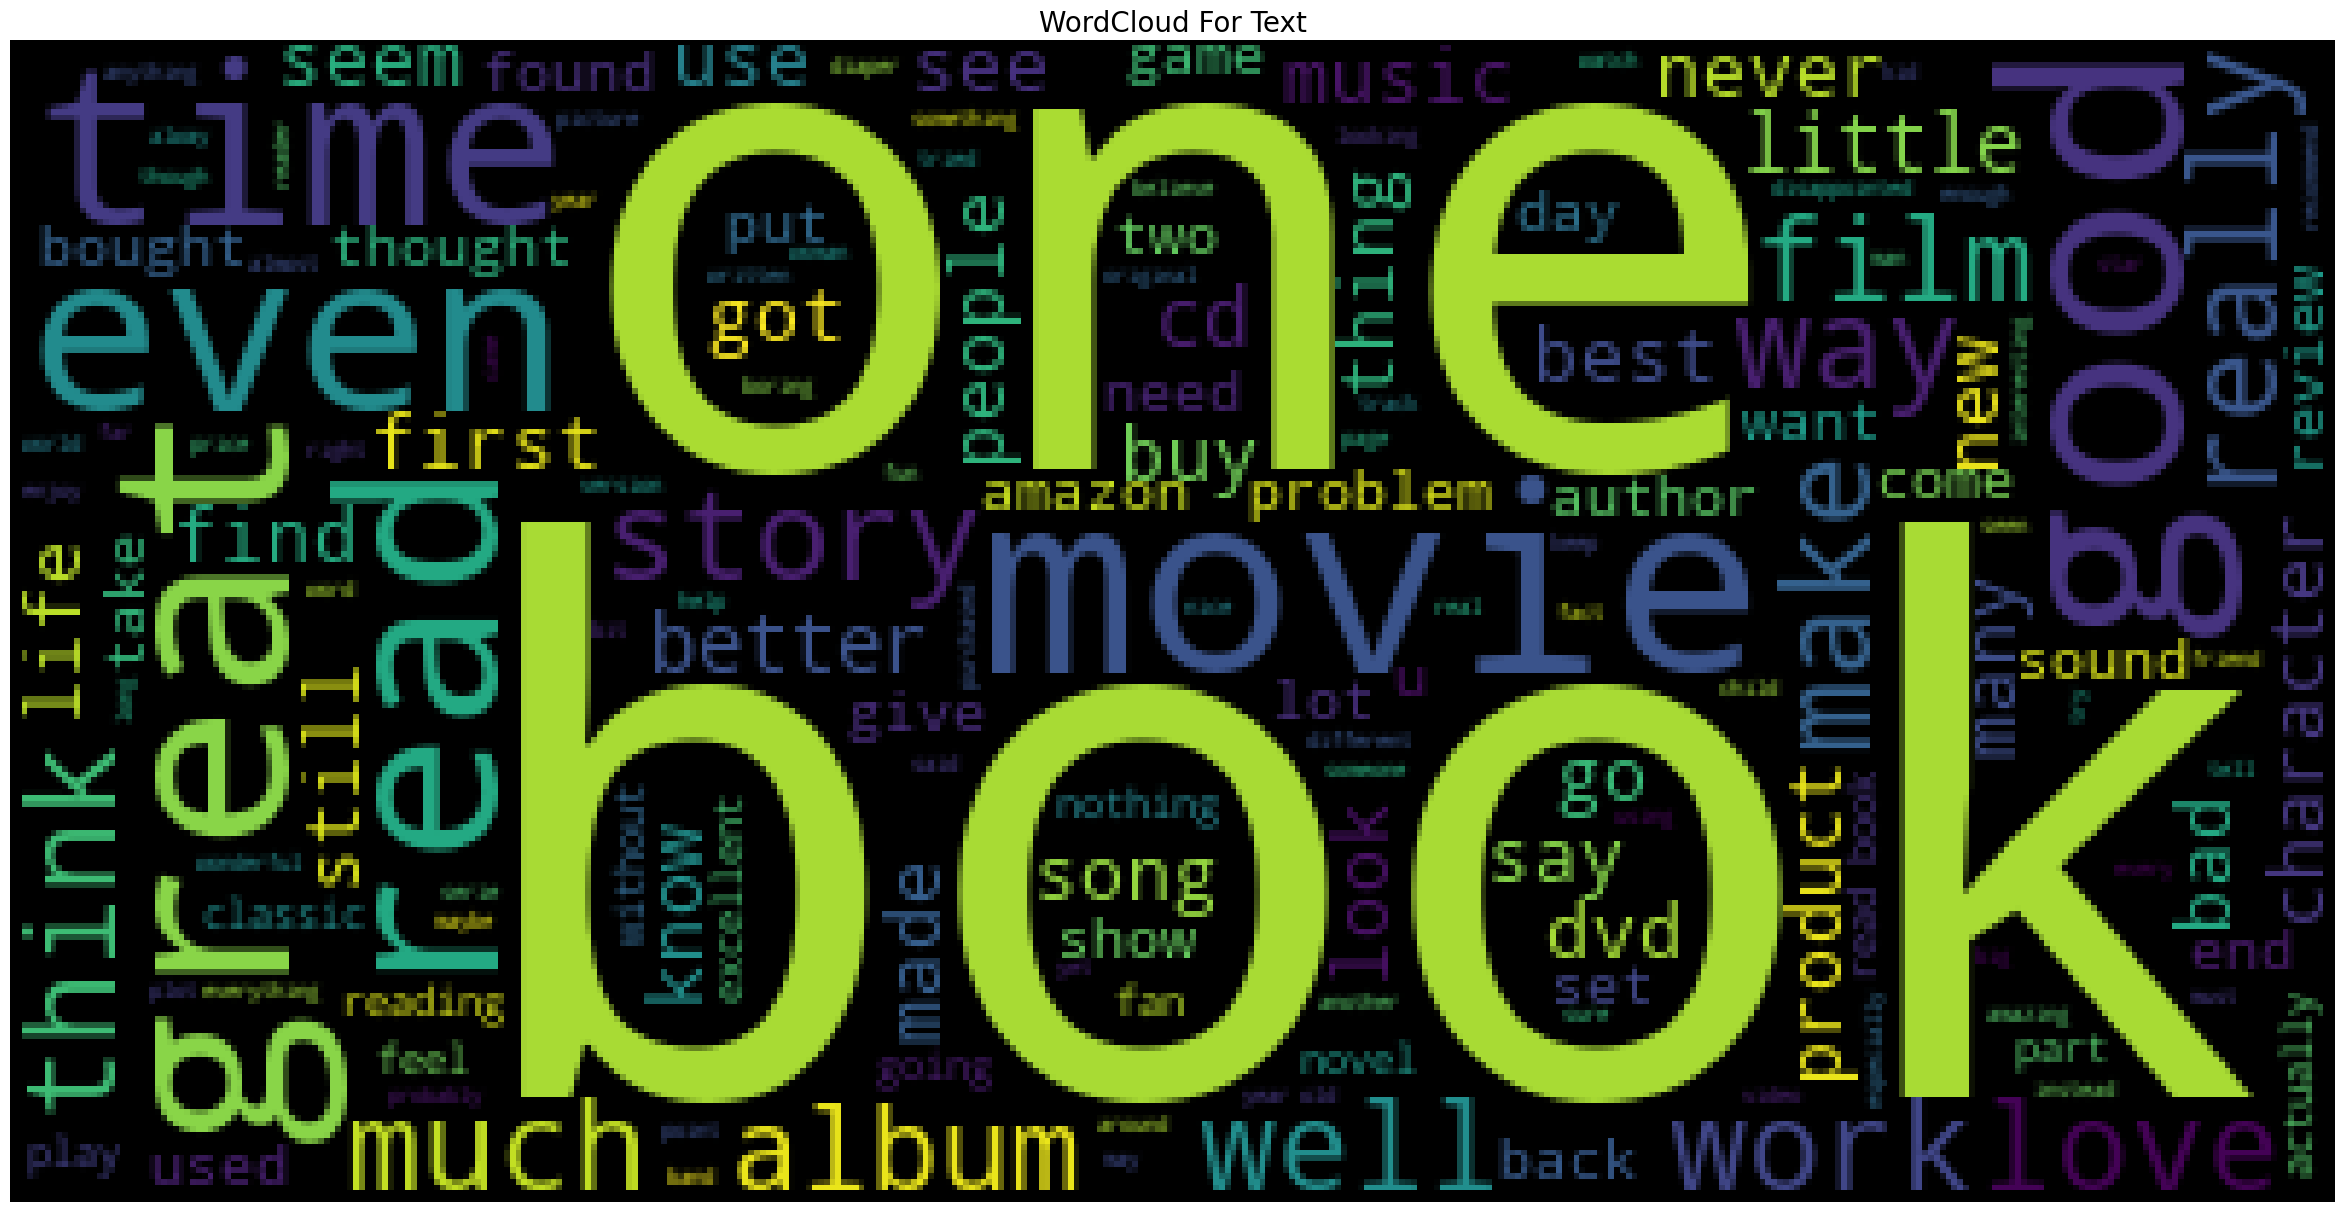

In [4]:
plt.figure(figsize=(30,20))
plt.imshow(WordCloud().generate(" ".join(X.iloc[:20000])))
plt.axis("off")
plt.title("WordCloud For Text",fontsize=20)
plt.show()

<a id="0.1"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" >Tokeniztion & pad_sequences<br><div> 


In [ ]:
voc_size = 20000
max_length = 100
tokenizer = Tokenizer(num_words=voc_size)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

del tokenizer, word_index, f

In [ ]:
# Load the object back from the file
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

del f
gc.collect()

In [ ]:
tokenizer.word_index.__len__()

In [ ]:
list(tokenizer.word_index.items())[:10]

In [ ]:
list_tokenized_train = tokenizer.texts_to_sequences(X_train)
print(list_tokenized_train[0])
print(X_train.array[0])
list_tokenized_val = tokenizer.texts_to_sequences(X_val)
print(list_tokenized_val[0])

<a id="0.1"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" >Model<br><div> 

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=voc_size, output_dim=64, input_length=max_length))
model.add(LSTM(units=32, return_sequences=True))
model.add(SpatialDropout1D(rate=0.2))  
model.add(LSTM(units=32))
model.add(Dense(1,activation='sigmoid'))
model.summary()

In [ ]:
checkpoint_cb = ModelCheckpoint("amazon_model.h5", save_best_only=True)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=2, validation_split=.1, callbacks=[checkpoint_cb])

In [ ]:
loss,accuracy = model.evaluate(test, test_lab)
print("Loss:", loss)
print("Accuracy:", accuracy)

In [ ]:
pd.DataFrame(history.history)

In [ ]:
prediction=model.predict(test)
y_pred=np.where(prediction>=.5,1,0)
df=pd.DataFrame()
df['actual'],df['pred']=test_lab,y_pred

In [ ]:
df

<a id="0.1"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" >Model Check<br><div> 

In [ ]:
CM = confusion_matrix(test_lab, y_pred)
sns.heatmap(CM,annot=True,center = True,fmt='g',cmap='Blues')
CM

In [ ]:
ClassificationReport = classification_report(test_lab,y_pred)
print('Classification Report is : ', ClassificationReport) 

<center>
  <h1 style="background-color:red; color:white; font-size:40px; font-weight:bold; font-family:Times New Roman; border:3px solid black;">Upvotes</h1>
</center>